# Model validation with observation data: Gauge and altimetry



In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import mikeio
import shapely
import glob
import os
import pandas as pd


In [3]:
# Functions
def plot_settings(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # remove plot border
    for spine in ax.spines.values():
        spine.set_visible(False)

def nse_rmse_statistics(Q_mod, Q_obs):
    """
    Compute Nash-Sutcliffe Efficiency (NSE) and Root Mean Square Error (RMSE)
    for modeled and observed discharge data.
    """
    # remove NaN values - dropping the same rows from both series
    valid_mask = Q_mod.notna() & Q_obs.notna()
    Q_mod = Q_mod[valid_mask]
    Q_obs = Q_obs[valid_mask]
    print()
    nse = 1 - ((Q_obs - Q_mod) ** 2).sum() / ((Q_obs - Q_obs.mean()) ** 2).sum()
    rmse = ((Q_obs - Q_mod) ** 2).mean() ** 0.5
    return nse, rmse

In [4]:
# ---------------------- Station Information ----------------------
chainage_dict = {"Q250018" : -3764,
        "Q250019" : -30794,
        "Q250020" : -3681,
        "Q250021" : 3900,
        "Q250078" : 26434,
        "Q250082" : 54135,
        "Q250090" : -2400,
        "Q250092" : -10576,
        "Q250097" : 61000

}

branch_dict = {"Q250018" : 'SKJERN_AA_DK5',
        "Q250019" : 'SDR_OMME_AA_DK5',
        "Q250020" : 'HOLTUM_AA_DK5',
        "Q250021" : 'BRANDE_AA_DK5',
        "Q250078" : 'SDR_OMME_AA_DK5',
        "Q250082" : 'SKJERN_AA_DK5',
        "Q250090" : 'SDR_OMME_AA_DK5',
        "Q250092" : 'GUNDESBOEL_AA_DK5',
        "Q250097" : 'SKJERN_AA_DK5'

}

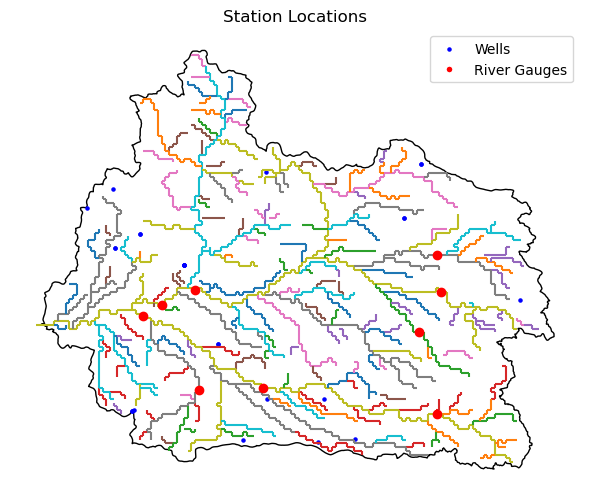

In [5]:
# ---------------------- Plot Domain, River Connectivity, Discharge stations ----------------------

fig, ax = plt.subplots(figsize=(6, 6))

# Domain data
domain_shp = gpd.read_file( r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")
domain_shp.plot(facecolor='none', edgecolor='black',ax=ax)

# River connectivity shapefile (simulation output)
riv_shp = gpd.read_file(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_RiverLinks.shp")
riv_shp.plot(column='Branch',ax=ax)
plot_settings(ax)


# Plot locations of river discharge stations
for stationID in branch_dict.keys():
    branch = branch_dict[stationID]
    chainage = chainage_dict[stationID]
    river = riv_shp.loc[riv_shp['Branch'] == branch]

    # get closest chainage
    closest_chain = river.iloc[(river['Chainage']-chainage).abs().argsort()[:1]]

    # get centroid of closest_chain
    centroid = shapely.centroid(closest_chain.geometry)
    centroid.plot(ax=ax,color='red',zorder=2)
    xloc = float(centroid.x.iloc[0])
    yloc = float(centroid.y.iloc[0])

    # plot stationID next to point
    # plt.text(x=xloc,y=yloc,s=stationID)

plt.title('Station Locations')

# Read in well locations
well_loc = gpd.read_file(r"..\MapsDK\Hdata\head_evel_SZ.csv")
well_loc = gpd.GeoDataFrame(well_loc, geometry=gpd.points_from_xy(well_loc['x'], well_loc['y']))
well_loc = well_loc.set_crs(domain_shp.crs)
well_loc.plot(ax=ax, color='blue', markersize=5, label='Wells')

# Add legend with manually specified labels
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='River Gauges', markerfacecolor='red', markersize=5))
ax.legend(handles=handles, loc='upper right')
plt.tight_layout()


In [17]:
# ---------------------- Load modeled and observed river discharge and water table depth (WTD) ----------------------


# Load Q observations
Q_obs = mikeio.read(r"..\MapsDK\Qdata\Q_filtered.dfs0")
Q_obs = Q_obs.to_dataframe()


# Load well obs (WTD)
well_obs = pd.DataFrame()
for filename in glob.glob(r"..\MapsDK\Hdata\Hdata_filtered\*.dfs0"):
    temp = mikeio.read(filename)
    temp = temp[0].to_dataframe()
    temp.columns = ['WTD']
    stationID = os.path.basename(filename)[0:-5]
    temp['StationID'] = stationID
    # set index to datetime
    temp.index = pd.to_datetime(temp.index)

    well_obs = pd.concat([well_obs, temp])

# Load modeled Q
Q_mod = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_M11.dfs0")
Q_mod = Q_mod.to_dataframe()

# Load modeled WTD
Wtd_SZ_mod = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_SZ.dfs0")
Wtd_SZ_mod = Wtd_SZ_mod.to_dataframe()


In [7]:
# ---------------------- Validation statistics for river discharge ----------------------

nse_rmse_results = {}
for stationID in branch_dict.keys():

    # combine data by date
    mod_daily = Q_mod[stationID].resample('D').mean()
    obs_daily = Q_obs[stationID].resample('D').mean()
    combined = mod_daily.to_frame(name='Modeled Q').join(obs_daily.to_frame(name='Observed Q'))

    # drop rows with NaN values
    combined = combined.dropna()
    
    nse, rmse = nse_rmse_statistics(combined['Modeled Q'], combined['Observed Q'])
    nse_rmse_results[stationID] = {'NSE': nse, 'RMSE': rmse}

for stationID, stats in nse_rmse_results.items():
    print(f"Station {stationID}: NSE = {stats['NSE']:.3f}, RMSE = {stats['RMSE']:.3f}")











Station Q250018: NSE = 0.096, RMSE = 0.477
Station Q250019: NSE = 0.574, RMSE = 0.550
Station Q250020: NSE = 0.586, RMSE = 0.282
Station Q250021: NSE = 0.612, RMSE = 0.171
Station Q250078: NSE = 0.800, RMSE = 2.176
Station Q250082: NSE = 0.786, RMSE = 3.262
Station Q250090: NSE = 0.655, RMSE = 1.106
Station Q250092: NSE = 0.657, RMSE = 0.487
Station Q250097: NSE = 0.672, RMSE = 6.244


Text(0.02, 0.5, 'Discharge (m³/s)')

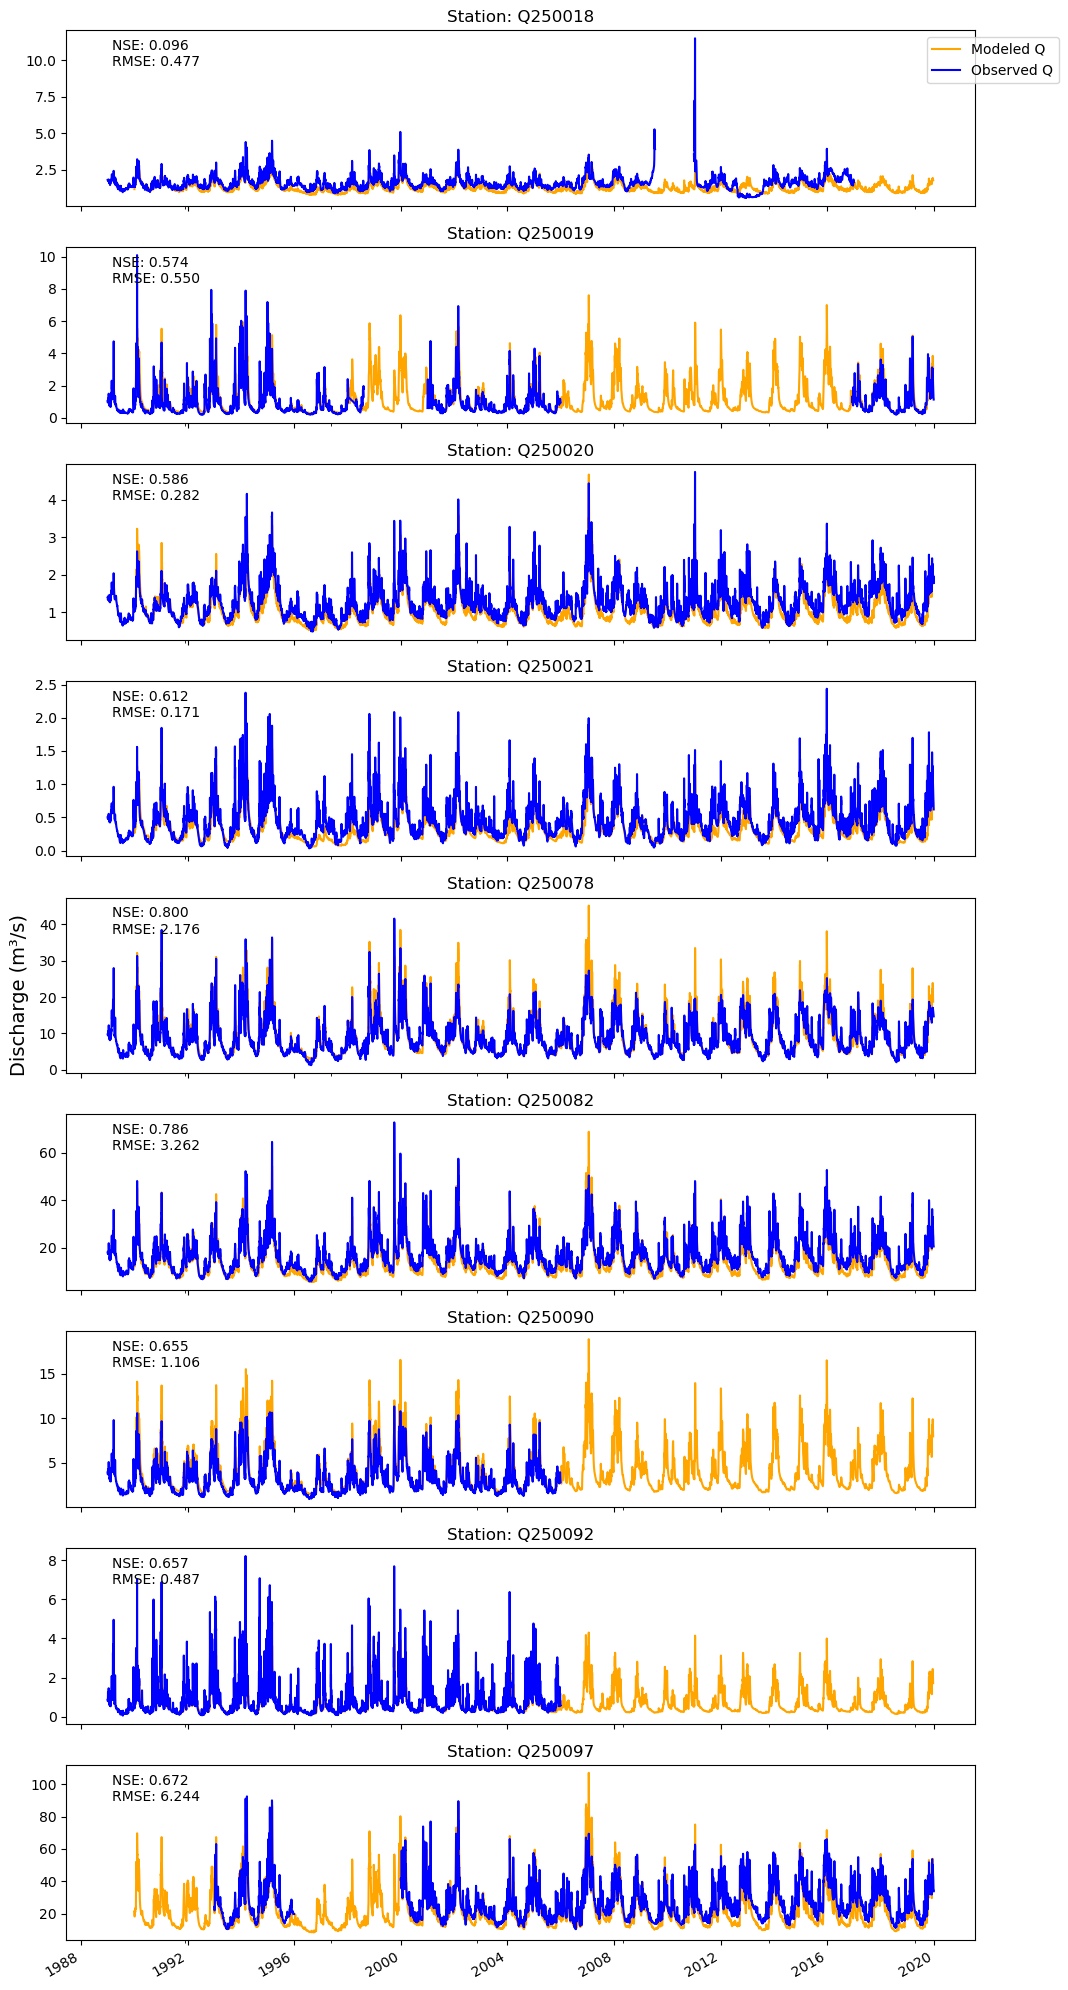

In [8]:
# ---------------------- Plot modeled vs observed Q for each station ----------------------

fig, ax = plt.subplots(nrows=len(branch_dict),ncols=1,sharex=True,figsize=(10,20))
i=0
for stationID in branch_dict.keys():
    
    Q_mod[stationID].plot(ax=ax[i], label=f'Modeled Q', color='orange')
    Q_obs[stationID].plot(ax=ax[i], label=f'Observed Q', color='blue')
    ax[i].set_title(f'Station: {stationID}')

    nse = nse_rmse_results[stationID]['NSE']
    rmse = nse_rmse_results[stationID]['RMSE']
    ax[i].text(0.05, 0.95, f'NSE: {nse:.3f}\nRMSE: {rmse:.3f}', transform=ax[i].transAxes, fontsize=10, verticalalignment='top')
    i += 1


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=ax[0].transAxes)
plt.tight_layout(rect=(0.025,0,1,1))

#fig.suptitle('Modeled vs Observed Discharge at River Stations', fontsize=16)
fig.supylabel('Discharge (m³/s)', fontsize=14)


In [24]:
# ---------------------- Validation statistics for WTD ----------------------

# resort this dataframe to have unique stationIDs as columns
well_obs['time'] = well_obs.index
wells_obs_long = well_obs.pivot_table(index='time', columns='StationID', values='WTD')


nse_rmse_results_wells = {}
for wellID in wells_obs_long.columns:

    # combine data by date
    mod_daily = Wtd_SZ_mod[wellID].resample('D').mean()
    obs_daily = wells_obs_long[wellID].resample('D').mean()
    combined = mod_daily.to_frame(name='Modeled WTD').join(obs_daily.to_frame(name='Observed WTD'))

    # drop rows with NaN values
    combined = combined.dropna()
    
    nse, rmse = nse_rmse_statistics(combined['Modeled WTD'], combined['Observed WTD'])
    nse_rmse_results_wells[wellID] = {'NSE': nse, 'RMSE': rmse}

for wellID, stats in nse_rmse_results_wells.items():
    print(f"Well {wellID}: NSE = {stats['NSE']:.3f}, RMSE = {stats['RMSE']:.3f}")





























Well 102.725_1: NSE = -325.764, RMSE = 17.184
Well 102.725_2: NSE = -547.758, RMSE = 17.452
Well 102.873_1: NSE = -1276.528, RMSE = 14.166
Well 103.1542_1: NSE = -10.435, RMSE = 1.271
Well 103.1653_1: NSE = -323.791, RMSE = 4.130
Well 103.1653_2: NSE = -0.078, RMSE = 0.242
Well 104.2190_1: NSE = -7.715, RMSE = 1.116
Well 105.374_1: NSE = -340.148, RMSE = 7.806
Well 113.111_1: NSE = -0.213, RMSE = 0.401
Well 114.1618_6: NSE = -3.209, RMSE = 1.555
Well 114.1631_1: NSE = -11.928, RMSE = 0.686
Well 83.1175_1: NSE = -7.074, RMSE = 1.222
Well 84.1167_1: NSE = -6.754, RMSE = 0.923
Well 86.2056_1: NSE = -36.388, RMSE = 1.410
Well 86.2056_2: NSE = -18.124, RMSE = 1.085
Well 93.1062_2: NSE = -19.664, RMSE = 1.683
Well 93.1062_3: NSE = -23.127, RMSE = 1.842
Well 93.795_1: NSE = -2355.340, RMSE = 10.350
Well 94.1920_1: NSE = -5.452, RMSE = 7.770
Well 94.1920_2: NSE = -16.051, RMSE = 4.247
Well 94.2476_1: NSE = -54.495, RMSE = 3.185
Well 94.2476_2: NSE = -53.156, RMSE = 3

Text(0.02, 0.5, 'WTD (m)')

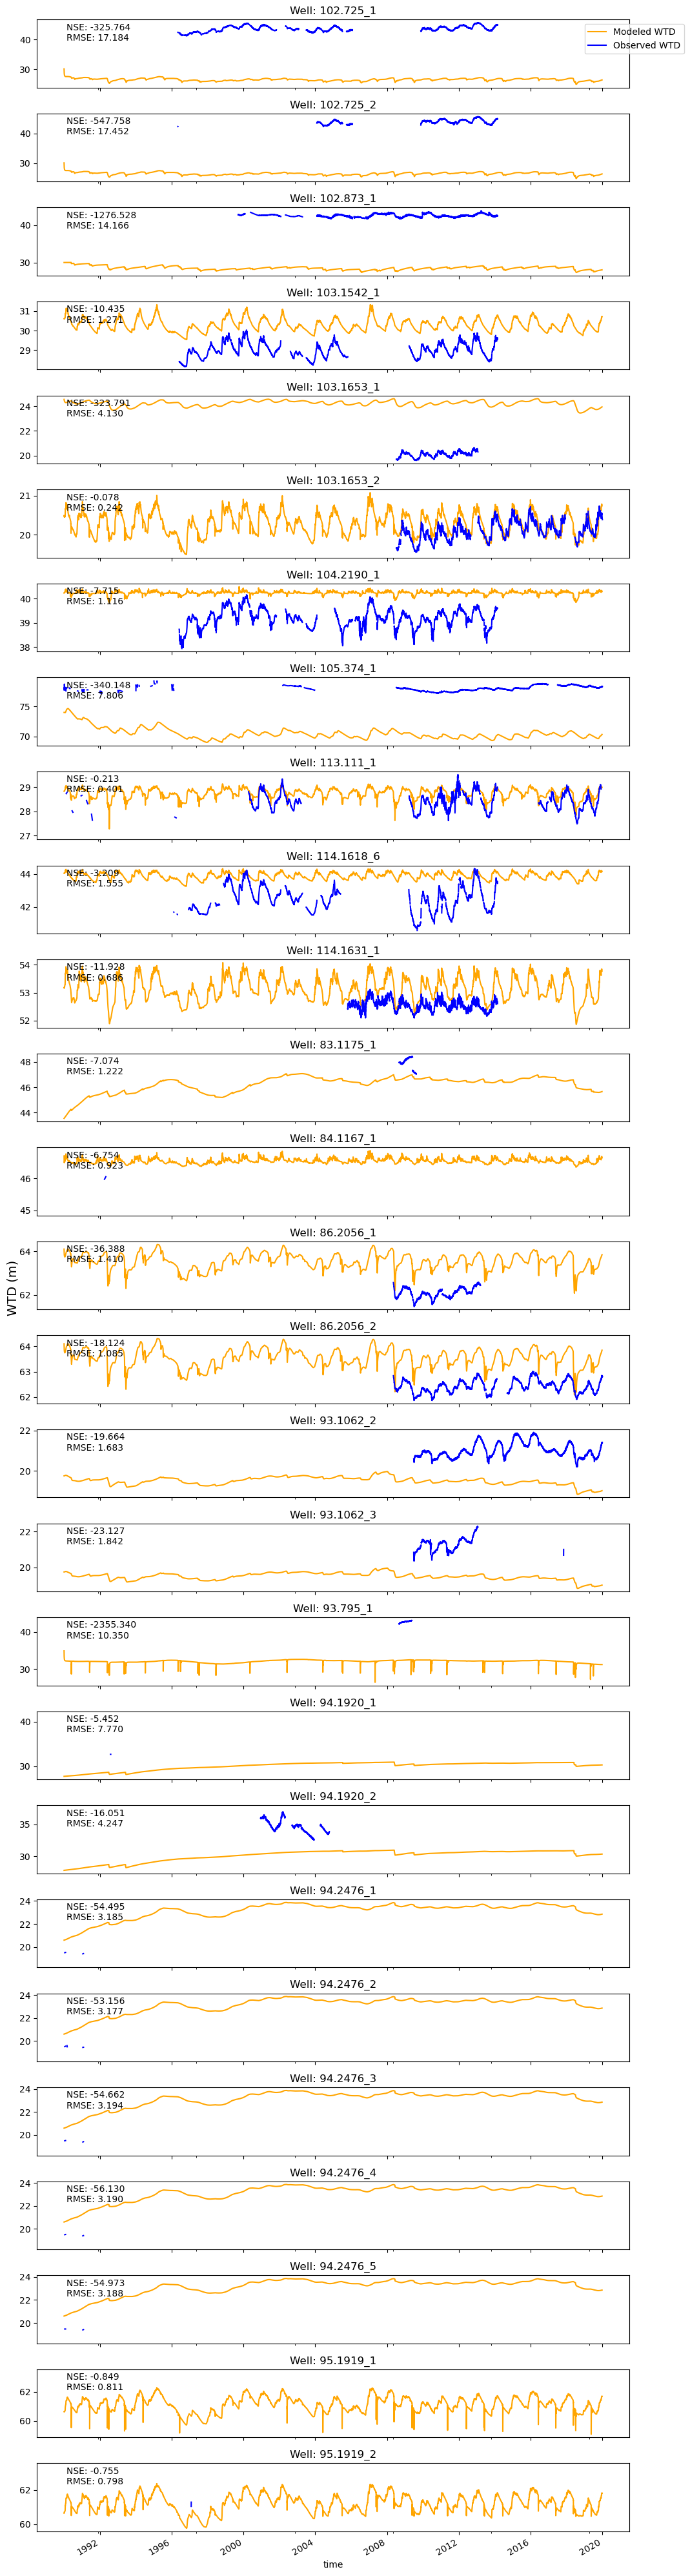

In [ ]:
# ---------------------- Plot modeled vs observed maps of WTD for time slices ----------------------

fig, ax = plt.subplots(nrows=len(wells_obs_long.columns),ncols=1,sharex=True,figsize=(10,40))
i=0
for wellID in wells_obs_long.columns:
    
    Wtd_SZ_mod[wellID].plot(ax=ax[i], label=f'Modeled WTD', color='orange')
    wells_obs_long[wellID].plot(ax=ax[i], label=f'Observed WTD', color='blue')
    ax[i].set_title(f'Well: {wellID}')

    rmse = nse_rmse_results_wells[wellID]['RMSE']
    ax[i].text(0.05, 0.95, f'RMSE: {rmse:.3f}', transform=ax[i].transAxes, fontsize=10, verticalalignment='top')
    i += 1


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=ax[0].transAxes)
plt.tight_layout(rect=(0.025,0,1,1))

fig.supylabel('WTD (m)', fontsize=14)

Summary of RMSE by Layer
-----------------------------------
Layer 1     | RMSE: 8.6691   | Data Points: 32661  | Wells: 15
Layer 2     | RMSE: 6.8460   | Data Points: 13642  | Wells: 7
Layer 3     | RMSE: 2.0499   | Data Points: 1272   | Wells: 2
Layer 4     | RMSE: 3.1904   | Data Points: 152    | Wells: 1
Layer 5     | RMSE: 3.1881   | Data Points: 152    | Wells: 1
Layer 6     | RMSE: 1.5549   | Data Points: 3871   | Wells: 1


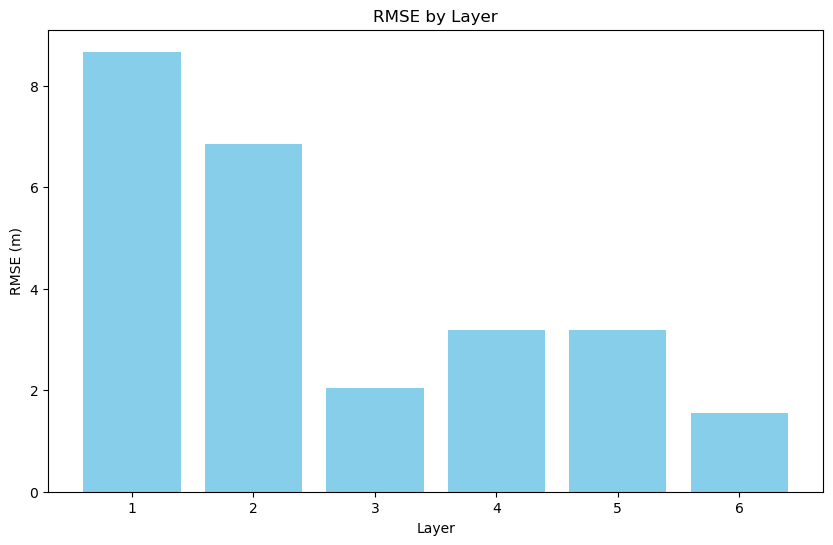

In [80]:
# ---------------------- Plot RMSE for each layer ----------------------

import re
import numpy as np
# Aggregate by layer
groups = {}
for col in wells_obs_long.columns:
    match = re.search(r'_(\d+)$', col)
    if match:
        suffix = match.group(1)
        if suffix not in groups:
            groups[suffix] = []
        groups[suffix].append(col)

# separate dataframes by each layer, stored in a dictionary
wells_obs_layers = {suffix: wells_obs_long[cols] for suffix, cols in groups.items()}
wells_mod_layers = {suffix: Wtd_SZ_mod[cols] for suffix, cols in groups.items()}


# Calculate RMSE for each layer
rmse_by_layer = {}
for layer, cols in wells_obs_layers.items():
    mod_daily = wells_mod_layers[layer].resample('D').mean()
    obs_daily = wells_obs_layers[layer].resample('D').mean()

    # align
    obs_daily = obs_daily[mod_daily.columns]
    mod_daily = mod_daily[obs_daily.columns]
    obs_df, mod_df = obs_daily.align(mod_daily, join='inner') # This joins data only present in both DataFrames

    assert obs_df.columns.equals(mod_df.columns), "Station columns are mismatched!"
    assert obs_df.index.equals(mod_df.index), "Timestamps are mismatched!"

    # # Compute RMSE for the entire dataframe (all values flattened)
    rmse = ((obs_df - mod_df) ** 2).stack().mean() ** 0.5

    # remove NaN values
    non_nan_count = obs_df.count().sum()

    # Store rmse and total number of data points for each layer in a dictionary
    rmse_by_layer[layer] = {
        'RMSE': rmse,
        'Total Data Points': non_nan_count,
        'Number of Wells': obs_df.shape[1]
    }

# Plot RMSE vs layer, ordered by layer number
rmse_by_layer = dict(sorted(rmse_by_layer.items(), key=lambda item: int (item[0])))

fig, ax = plt.subplots(figsize=(10, 6))
layers = list(rmse_by_layer.keys())
rmse_values = [rmse_by_layer[layer]['RMSE'] for layer in layers]
ax.bar(layers, rmse_values, color='skyblue')
ax.set_xlabel('Layer')
ax.set_ylabel('RMSE (m)')
ax.set_title('RMSE by Layer')

# print number of data points for each layer
print("Summary of RMSE by Layer\n" + "-"*35)
for layer in layers:
    rmse = rmse_by_layer[layer]['RMSE']
    n_points = rmse_by_layer[layer]['Total Data Points']
    n_wells = rmse_by_layer[layer]['Number of Wells']
    
    print(f"Layer {layer:<5} | RMSE: {rmse:<8.4f} | Data Points: {n_points:<6} | Wells: {n_wells}")

